In [4]:
import pandas as pd
import numpy as np
import pdb
import math
import matplotlib.pyplot as plt
from sklearn import linear_model
from itertools import product

df = pd.read_csv('magcup.csv')

n = 10 # This is the assumed sampling number
# wは制御因子, xは誤差因子
x_labels = [c for c in df.columns if 'x' in c]
w_labels = [c for c in df.columns if 'w' in c]
df_control = df[x_labels]
df_error = df[w_labels]
N = len(df) # 8
N_x = len(x_labels)


In [5]:
-10*math.log10(1/n*sum([1/x**2 for x in df_error.iloc[:,0]]))

16.01048327730577

IndexError: list index out of range

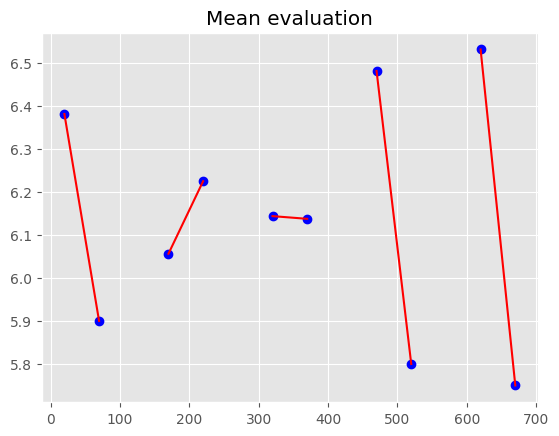

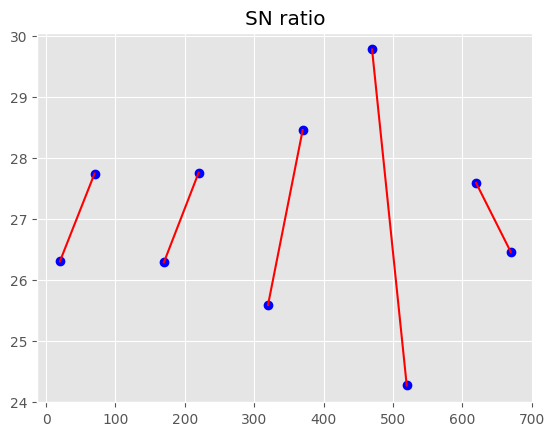

In [7]:
SN = [0]*N
for i, row in df_error.iterrows():
    #望目特性のSN比の公式
    SN[i] = 10*math.log10(row.mean()**2/row.var()-1/n)
    #望大特性のSN比の公式(非推奨)
    #SN[i] = -10*math.log10(1/n*sum([1/x**2 for x in row]))
    #望大特性・望小特性の計算式は分母に分散（ばらつき）の情報が入っていないので、
    #1段階目のパラメータ選択に使うSN比としての意義がないかもしれない。　
    #参考: https://seinzumtode.hatenadiary.jp/entry/2024/09/06/152834

# 改善すべき因子の抽出 (第一段階: SN比を利用)
SN_mean_difference = [0]*N_x
sn_mean_a = [0]*N_x
sn_mean_b = [0]*N_x
for i in range(N_x):
    x = x_labels[i]
    df_x = df_control[x]
    for j, sn in enumerate(SN):
        if df_x[j]==1:
            sn_mean_a[i] += SN[j]
        else:
            sn_mean_b[i] += SN[j]
    sn_mean_a[i] = sn_mean_a[i] / (N/2)
    sn_mean_b[i] = sn_mean_b[i] / (N/2)
    SN_mean_difference[i] = sn_mean_a[i] - sn_mean_b[i]
    
# 目標値のあわせこみ(第二段階: 平均値を利用)
Mean = df_error.mean(axis=1).tolist()
Mean_mean_difference = [0]*N_x
mean_mean_a = [0]*N_x
mean_mean_b = [0]*N_x
for i in range(N_x):
    x = x_labels[i]
    df_x = df_control[x]
    for j, sn in enumerate(Mean):
        if df_x[j]==1:
            mean_mean_a[i] += Mean[j]
        else:
            mean_mean_b[i] += Mean[j]
    mean_mean_a[i] = mean_mean_a[i] / (N/2)
    mean_mean_b[i] = mean_mean_b[i] / (N/2)
    Mean_mean_difference[i] = mean_mean_a[i] - mean_mean_b[i]

# 要因効果図の描画
offset = 150
initial_x = 20
width = 50
x_a = [initial_x]
x_b = [initial_x+width]
# x座標生成
for i in range(N_w):
    x_a.append(x_a[-1]+offset)
    x_b.append(x_b[-1]+offset)

plt.figure(1)
plt.title("SN ratio")
plt.figure(2)
plt.title("Mean evaluation")

# 要因効果図の描画
for i in range(N_x):
    sn_a = sn_mean_a[i]
    sn_b = sn_mean_b[i]
    plt.figure(1)
    plt.plot(x_a[i],sn_a,'bo')
    plt.plot(x_b[i],sn_b,'bo')
    plt.plot((x_a[i],x_b[i]),(sn_a,sn_b),'r')

    mean_a = mean_mean_a[i]
    mean_b = mean_mean_b[i]
    plt.figure(2)
    plt.plot(x_a[i],mean_a,'bo')
    plt.plot(x_b[i],mean_b,'bo')
    plt.plot((x_a[i],x_b[i]),(mean_a,mean_b),'r')

# 平均値の描画
sn_average = pd.DataFrame(SN).mean()
mean_average = pd.DataFrame(Mean).mean()
plt.figure(1)
plt.plot((x_a[0],x_b[-1]),(sn_average,sn_average),'k--')
plt.figure(2)
plt.plot((x_a[0],x_b[-1]),(mean_average,mean_average),'k--')

# ラベルの描画
for i in range(N_w):
    plt.figure(1)
    axes = plt.gca()
    yl = axes.get_ylim()[0]
    plt.text(x_a[i], yl, 'x'+str(i+1), fontsize=12)

    plt.figure(2)
    axes = plt.gca()
    yl = axes.get_ylim()[0]
    plt.text(x_a[i], yl, 'x'+str(i+1), fontsize=12)

plt.show(block=False)

# パラメータの最適化(重回帰分析)
model = linear_model.LinearRegression()
Y = df_error.mean(axis=1)
X = df_control
model.fit(X,Y)
print(model.coef_)
print(model.intercept_)

# combi = [p for p in product((0,1),(0,1),(0,1),(0,1),(0,1),(0,1))]
patterns = list(product((0,1),(0,1),(0,1),(0,1),(0,1),(0,1)))
x = np.array(patterns)
y = model.predict(x)
y = y.reshape(len(y),1)
complete = np.hstack((x,y))
df_complete = pd.DataFrame(complete,columns=('X1','X2','X3','X4','X5','X6','Y'))
df_complete = df_complete.sort_values(by=['Y'],ascending=False)
print('**********************')
print('Optimal solution')
print('**********************')
print(df_complete.iloc[0])


#input("Press Enter to exit.")
